# Dynamics Homework 2

Liam Dubay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
G = 4*np.pi**2 # solar system units

In [2]:
class Binary:
    def __init__(self, mass1, mass2, separation, phase=0):
        """
        Parameters
        ----------
        mass1 : float
            Mass of primary star in solar masses
        mass2 : float
            Mass of secondary star in solar masses
        separation : float
            Separation of binary in AU
        phase : float
            Initial phase of binary from 0 to 1. A phase of 0 
            starts the primary mass on the positive x-axis.
        
        """
        self.m1 = mass1
        self.m2 = mass2
        self.mtot = mass1 + mass2
        self.sep = separation
        self.a1 = self.m2 / self.mtot * self.sep
        self.a2 = self.m1 / self.mtot * self.sep
        # Convert phase to angle
        self.phi0 = phase * 2*np.pi
        self.T = np.sqrt(self.sep**3/self.mtot)
        
    def acceleration(self, t, test_position):
        """
        Gravitational acceleration on a test particle due to the binary.
        """
        pos1, pos2 = self.positions(t)
        r1 = test_position - pos1
        r2 = test_position - pos2
        accel = -G * (self.m1 * r1 / np.sqrt(np.sum(r1**2))**3 + self.m2 * r2 / np.sqrt(np.sum(r2**2))**3)
        return accel
    
    def positions(self, t):
        """
        Cartesian positions of the two masses as a function of time.
        """
        # Orbital phase of the primary, m1
        phi = 2*np.pi/self.T * t + self.phi0
        # Keep phase < 2pi
        phi = phi - 2*np.pi * np.floor(phi / (2*np.pi))
        # Cartesian positions of m1 and m2
        pos1 = self.a1 * np.array([np.cos(phi), np.sin(phi)])
        pos2 = self.a2 * np.array([np.cos(phi+np.pi), np.sin(phi+np.pi)])
        return pos1, pos2
        
    def potential(self, t, test_position):
        """
        Gravitational potential of a test particle at a given position and time.
        """
        pos1, pos2 = self.positions(t)
        r1 = np.sqrt(np.sum((test_position - pos1)**2))
        r2 = np.sqrt(np.sum((test_position - pos2)**2))
        pot = -G * (self.m1 / r1 + self.m2 / r2)
        return pot

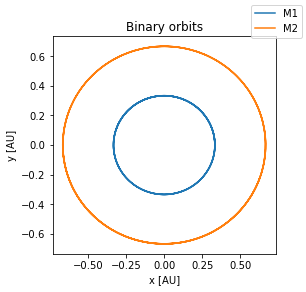

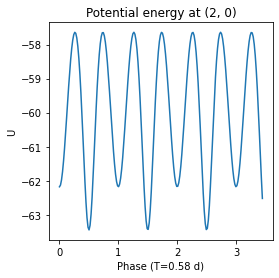

In [3]:
# Test code for binary star
binary = Binary(2, 1, 1, phase=0)
tarr = np.arange(0, 2, 0.01)

# Plot orbits
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(binary.positions(tarr)[0][0], binary.positions(tarr)[0][1], label='M1')
ax.plot(binary.positions(tarr)[1][0], binary.positions(tarr)[1][1], label='M2')
ax.set_title('Binary orbits')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
fig.legend()
plt.show()

# Plot potential energy at test position
test_pos = np.array([2, 0])
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(tarr / binary.T, [binary.potential(t, test_pos) for t in tarr])
ax.set_title('Potential energy at (2, 0)')
ax.set_xlabel(f'Phase (T={binary.T:.02f} d)' % binary.T)
ax.set_ylabel('U')
plt.show()

In [4]:
class TestParticle():
    """Parameters, values, and functions for a massless test particle."""
    
    def __init__(self, primary_mass, a0, phase=0):
        """
        Initialize test particle.
        
        Parameters
        ----------
        primary_mass : float
            Mass of primary (or total mass of binary) centered at
            the origin in solar masses.
        a0 : float
            Initial semi-major axis in AU.
        phase : float, optional
            Initial orbital phase, from 0 to 1. Default is 0,
            which is on the positive x-axis.
        
        """
        # Convert phase to angle
        phi = phase * 2*np.pi
        # Start at phase on circular orbit
        self.position = a0 * np.array([np.cos(phi), np.sin(phi)])
        v_circ = np.sqrt(G * primary_mass / a0)
        self.velocity = v_circ * np.array([-np.sin(phi), np.cos(phi)])
        
    def accelerate(self, tstep, acceleration, update=True):
        """
        Accelerate body over the integration time step and re-calculate velocity.
        
        Parameters
        ----------
        tstep : float
            Integration time step in years.
        acceleration : numpy.ndarray
            Acceleration vector in solar system units.
        update : bool
            If True, update velocity in place. Default is True.
        """
        
        velocity = self.velocity + acceleration * tstep
        if update:
            self.velocity = velocity
        return velocity
    
    def angular_momentum(self):
        """
        Calculate the z-component of specific angular momentum.
        """
        
        return np.cross(self.position, self.velocity)
    
    def kinetic_energy(self):
        """
        Calculate the specific kinetic energy.
        """
        
        return 0.5 * np.sum(self.velocity**2)

    def move(self, tstep, update=True):
        """
        Move position over the integration time step according to the current velocity.
        
        Parameters
        ----------
        tstep : float
            Integration time step in years.
        update : bool
            If True, update position in place. Default is True.
        """
        
        position = self.position + self.velocity * tstep
        if update:
            self.position = position
        return position

In [6]:
class CircularThreeBody:
    """Set up and run a circular-restricted 3-body problem."""
    
    def __init__(self, m1, m2, sep, a0, phase=0):
        """
        Initialize circular-restricted 3-body system with a central massive
        binary and a test mass on a circular orbit.
        
        Parameters
        ----------
        m1 : float
            Mass of primary in solar masses.
        m2 : float
            Mass of secondary in solar masses.
        sep : float
            Binary separation in AU.
        a0 : float
            Semi-major axis of test particle initial circular orbit in AU.
        phase : float, optional
            Initial phase of binary, with 0 corresponding to a conjunction
            with the primary closer to the test particle, and 0.5 corresponding
            to a conjunction with the secondary closer to the test particle.
            The default is 0.
        
        """
        self.binary = Binary(m1, m2, sep, phase=phase)
        self.planet = TestParticle(m1+m2, a0, phase=0)
        self.orbit_initial = self.orbital_elements()
        
    def jacobi(self, t):
        """
        Calculate Jacobi constant for circular binary + test particle system.
        """
        mean_motion = 2 * np.pi / self.binary.T
        energy_total = self.planet.kinetic_energy() + self.binary.potential(t, self.planet.position)
        return 2 * (mean_motion * self.planet.angular_momentum() - energy_total)
        
    def integrate(self, tmax, tstep):
        """
        Integrate circular-restricted 3-body orbits using leapfrog integration.
        """
        # Initialize output arrays
        tout = []
        x = []
        xdot = []
        jacobi = []

        # Initial values
        t = 0
        old_t = -1
        with tqdm(total = int(tmax)) as pbar:
            while t < tmax:
                if np.around(2*t/tstep) % 2:
                    # Half-step: calculate acceleration and update velocity
                    acceleration = self.binary.acceleration(t, self.planet.position)
                    self.planet.accelerate(acceleration, tstep)
                else:
                    # Full step: update position
                    old_y = self.planet.position[1]
                    self.planet.move(tstep)
                    # Record x-position, x-velocity, and Jacobi once per orbit
                    if self.planet.position[1] > 0 and old_y <= 0 and self.planet.velocity[1] > 0:
                        tout.append(t)
                        x.append(self.planet.position[0])
                        xdot.append(self.planet.velocity[0])
                        jacobi.append(self.jacobi(t))
                    # Update progress bar each year
                    if t >= old_t + 1:
                        old_t = t
                        pbar.update(1)
                t += tstep/2

        self.history = {
            't': tout,
            'x': x,
            'xdot': xdot,
            'Cj': jacobi
        }
        self.orbit_final = self.orbital_elements()
        return self.history
    
    def orbital_elements(self):
        """
        Convert planet's position and velocity into its Keplerian orbital elements about the origin.
        """
        M = self.binary.mtot
        r = np.sqrt(np.sum(self.planet.position**2))
        v = np.sqrt(np.sum(self.planet.velocity**2))
        a = (2/r - v**2/(G*M))**-1
        h = self.planet.angular_momentum()
        e = np.sqrt(max(1 - h**2/(a*G*M), 0))
        # eccentricity vector
        e_vec = h/(G*M) * np.array([self.planet.velocity[1], -self.planet.velocity[0]]) - self.planet.position/r
        # argument of periapsis (from positive x-axis)
        arg_peri = np.arctan2(e_vec[1], e_vec[0])
        return a, e, arg_peri

In [7]:
m1 = 0.6897
m2 = 0.20255
sep = 0.22431
a0 = 0.7048
sys1 = CircularThreeBody(m1, m2, sep, a0, phase=0)
hist = sys1.integrate(1e4, 1e-3)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:40<00:00, 17.22it/s]


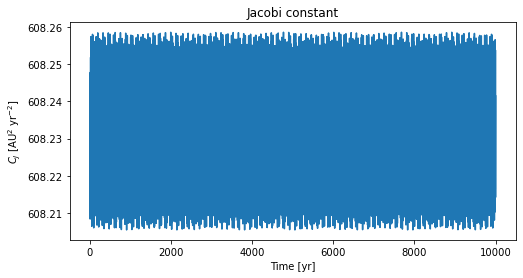

In [8]:
# Plot Jacobi constant
hist = sys1.history
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(hist['t'], hist['Cj'])
ax.set_title('Jacobi constant')
ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$C_J$ [AU$^2$ yr$^{-2}$]')
ax.ticklabel_format(useOffset=False)
plt.show()

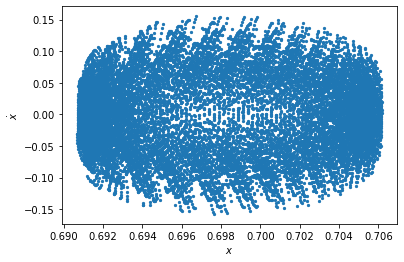

In [9]:
# Surface of section plot
hist = sys1.history
fig, ax = plt.subplots()
ax.scatter(hist['x'], hist['xdot'], s=5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot x$')
plt.show()

In [ ]:
sys2 = CircularThreeBody(0.6897, 0.20255, 0.22431, 0.7048, phase=0.5)
hist = sys2.integrate(1e4, 1e-3)

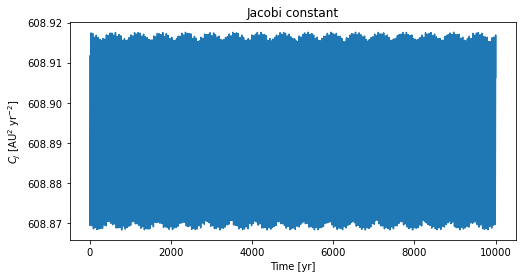

In [142]:
# Plot Jacobi constant
hist = sys2.history
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(hist['t'], hist['Cj'])
ax.set_title('Jacobi constant')
ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$C_J$ [AU$^2$ yr$^{-2}$]')
ax.ticklabel_format(useOffset=False)
plt.show()

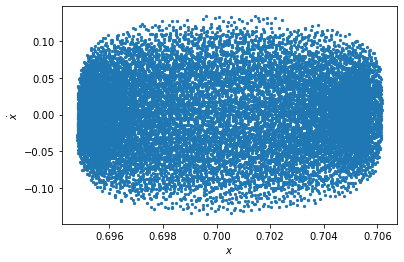

In [141]:
# Surface of section plot
hist = sys2.history
fig, ax = plt.subplots()
ax.scatter(hist['x'], hist['xdot'], s=5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot x$')
plt.show()

In [140]:
sys2.orbit_final

(0.714619830082445, 0.021002274747804597, -0.4704175648327917)

In [14]:
sys3 = CircularThreeBody(m1, m2, sep, a0/2, phase=0)
hist = sys3.integrate(1e2, 1e-4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


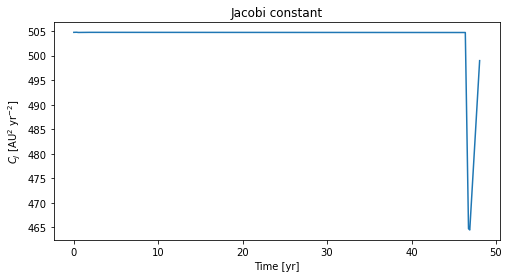

In [15]:
# Plot Jacobi constant
hist = sys3.history
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(hist['t'], hist['Cj'])
ax.set_title('Jacobi constant')
ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$C_J$ [AU$^2$ yr$^{-2}$]')
ax.ticklabel_format(useOffset=False)
plt.show()

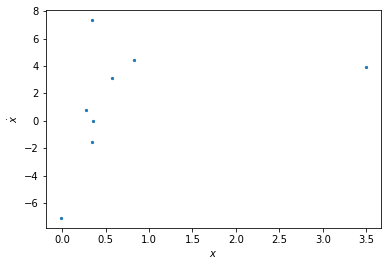

In [16]:
# Surface of section plot
hist = sys3.history
fig, ax = plt.subplots()
ax.scatter(hist['x'], hist['xdot'], s=5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot x$')
plt.show()

In [17]:
hist

{'t': [0,
  0.31679999999997327,
  0.5316999999999497,
  1.8758000000017463,
  46.37190000097762,
  46.75120000099021,
  46.90100000099518,
  48.06880000103395],
 'x': [0.3524,
  0.34742928984812543,
  0.8250906375823334,
  3.492754736549558,
  0.576588673388709,
  0.2750364891269802,
  0.34382178636484395,
  -0.00870335220154188],
 'xdot': [-0.0,
  -1.5342943526999182,
  4.444810754791173,
  3.9533688491156926,
  3.1567973311897424,
  0.7652343790625185,
  7.3354853582946635,
  -7.084006181380893],
 'Cj': [504.7502378129578,
  504.7713550053621,
  504.7284343874167,
  504.7497903003165,
  504.7169539150447,
  464.7389483932417,
  464.4891445700466,
  498.98446324486633]}